In [1]:
import os
# Verificación y ubicación (y descarga de archivos en colab)
directory_path = os.getcwd()
folder_name = os.path.basename(directory_path)
if folder_name != 'analysis':
    try:
        os.chdir("/content/CoNet/Tp Final/analysis")
    except FileNotFoundError:
        !git clone https://github.com/facundojgarcia02/CoNet.git
        os.chdir("/content/CoNet/Tp Final/analysis")

Cloning into 'CoNet'...
remote: Enumerating objects: 715, done.
remote: Counting objects: 100% (243/243), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 715 (delta 112), reused 239 (delta 108), pack-reused 472
Receiving objects: 100% (715/715), 128.17 MiB | 19.56 MiB/s, done.
Resolving deltas: 100% (317/317), done.
Checking out files: 100% (111/111), done.


In [2]:
from Propagation.utils import ReachFinder
import numpy as np
import pandas as pd
import datetime
import pickle
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 120
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'
rcParams['axes.grid'] = True

try:
    with open("release_data.df", "rb") as pickle_file:
        data_df = pickle.load(pickle_file)
except FileNotFoundError:
    # Loading Network
    G = nx.read_gexf("../state_files/PyPi Network V4.gexf")
    # Loading release date data
    with open("../state_files/Filtered Releases.pickle", "rb") as f:
        releases_dict = pickle.load(f)
    known_dates_dict = {lib: {ver: date for ver, date in version_dict.items()
                            if date is not None}
                        for lib, version_dict in releases_dict.items()}
    data_dict = dict()
    now = datetime.datetime.now()
    data_dict["first date"] = {lib: (now - min(version_dict.values())).days for lib, version_dict in known_dates_dict.items()
                            if version_dict}  # False sii version_dict está vacío.
    data_dict["last date"] = {lib: (now - max(version_dict.values())).days for lib, version_dict in known_dates_dict.items()
                            if version_dict}  # False sii version_dict está vacío.
    data_dict["updates"] = {lib: len(version_dict.values()) for lib, version_dict in releases_dict.items()}

    finder = ReachFinder(G)
    reached_libs = finder.find_all_nodes()
    reach = {lib: len(reached_from_lib) for lib, reached_from_lib in reached_libs.items()}
    data_dict["reach"] = reach
    del(G)
    del(reached_libs)
    data_df = pd.DataFrame.from_dict(data=data_dict)
    with open("release_data.df", "wb") as pickle_file:
        pickle.dump(data_df, pickle_file)

In [3]:
sample_df = data_df.dropna().sample(200, random_state=42).reset_index()

In [8]:
# plt.scatter(x=data_df["updates"], y=data_df["last date"], c=np.log10(data_df["reach"]),
#             edgecolors="k", alpha=0.5, zorder=10)
# plt.xscale("log")
# plt.yscale("log")
# plt.xlabel("Updates")
# plt.ylabel("Días desde última update")
# plt.colorbar(label=r"$\log_{10}$(Alcance)")

# plt.show()

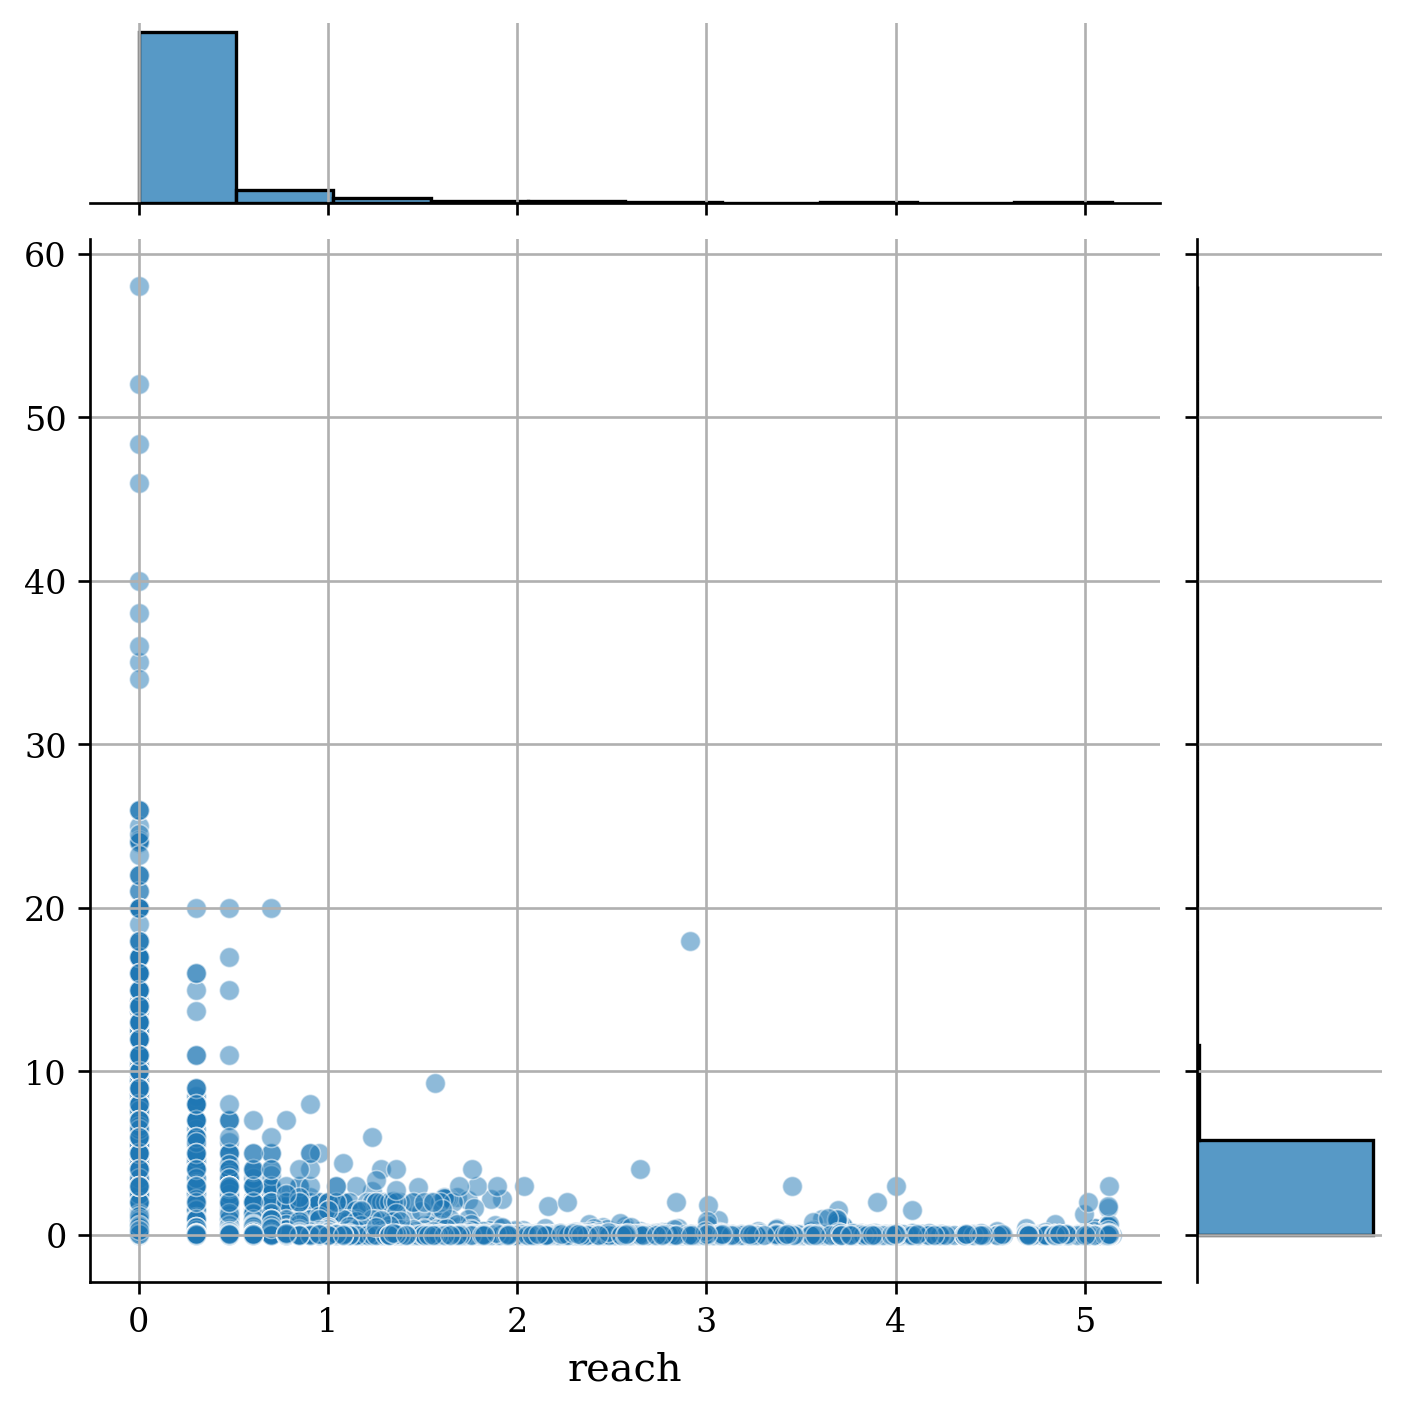

In [19]:
jg = sns.JointGrid(data=data_df, x=np.log10(data_df["reach"]), y=data_df["updates"]/(data_df["first date"] - data_df["last date"]), )
jg.plot_joint(sns.scatterplot, alpha=0.5)
jg.plot_marginals(sns.histplot, kde=False, bins=10)
plt.show()